# 2018-05-07 Vers un meilleur réseau entrainé sur MC
Avec du des relus pour sparsifier la première couche, 16 orientations de $\theta$ pour faire plus proche de la biologie.

Commençons par générer les motionclouds sur du B$\theta$ de 1 à 15° :

In [13]:
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio

downscale = 1
fig_width = 21
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

N_theta = 120
N_theta_test = 12

#16 angles entre 0 et pi
theta_values = np.linspace(0,np.pi,16)

#120 values de traning, 12 de test
bw_values = np.pi*np.logspace(-7,-3.5, N_theta, base=2)
bw_test_values = np.pi*np.logspace(-7,-3.5, N_theta_test, base=2)

#generer training
for t in theta_values :
    if not os.path.exists('./16_clouds_easy/%s' % t): #si le folder n'existe pas on le crée
        os.makedirs('./16_clouds_easy/%s' % t)
    
    for i_ax, B_theta in enumerate(bw_values):
        mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_V=0, theta=t, B_theta=B_theta)
        im = mc.random_cloud(mc_i)
        im = im
        imageio.imwrite('./16_clouds_easy/%s/B0 %s.png' % (t , (B_theta*180/np.pi) ) , im[:, :, 0])

#generer test
for t in theta_values :
    if not os.path.exists('./16_clouds_easy/%s' % t): #si le folder n'existe pas on le crée
        os.makedirs('./16_clouds_easy/%s' % t)
    if not os.path.exists('./16_clouds_easy_test/%s' % t):
        os.makedirs('./16_clouds_easy_test/%s' % t)

    for i_ax, B_theta in enumerate(bw_test_values):
        mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_V=0, theta=t, B_theta=B_theta)
        im = mc.random_cloud(mc_i)
        
        imageio.imwrite('./16_clouds_easy_test/%s/B0 %s.png' % (t , (B_theta*180/np.pi) ) , im[:, :, 0])

Cette fois ci on utilise les images en fullscale (256x256) :

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=6, shuffle=True,
                                             num_workers=1, drop_last = True)

#test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=6,shuffle=False,
                                             num_workers=1, drop_last = True)

Un test de display :


  8
  2
 10
 12
 11
  4
[torch.LongTensor of size 6]



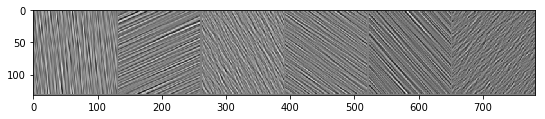

Process Process-2:
Traceback (most recent call last):
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [9, 9]

# pour montrer une image
def imshow(img):
    img = img / 2 + 0.5    #de-normaliser
    npimg = img.numpy()    #convertir en array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# on loop sur un batch
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(labels)
imshow(torchvision.utils.make_grid(images))

On utilise la fonction leaky_relu, qui est une relu normale mais avec une pente de x * 1e-2 quand x<0. Voir le benchmark de performance dans le notebook 2018-05-07_02 :


Le réseau, avec en entrée les images en 256 qui passent en RELU et en sortie la cross-entropy loss :

In [15]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu1 = nn.Linear(256, 200)

        self.conv1 = nn.Conv2d(1, 6, 20)
        self.pool = nn.MaxPool2d(2,2)
        #self.conv2 = nn.Conv2d(6, 6, 5)a

        self.fc1 = nn.Linear(63720,10000)
        self.fc2 = nn.Linear(10000,1000)
        self.fc3 = nn.Linear(1000,100)

        self.outlayer = nn.Linear(100,16)

    def forward(self, x):
        x = F.leaky_relu(self.relu1(x))

        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1) #reshape from conv to linear

        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))

        x = self.outlayer(x)
        return x
        
model = Net()
print(model)

RuntimeError: $ Torch: not enough memory: you tried to allocate 2GB. Buy new RAM! at /opt/conda/conda-bld/pytorch-cpu_1518282373170/work/torch/lib/TH/THGeneral.c:253

In [16]:
#TEST AVEC MOINS GRAND 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu1 = nn.Linear(128, 200)

        self.conv1 = nn.Conv2d(1, 6, 20)
        self.pool = nn.MaxPool2d(2,2)
        #self.conv2 = nn.Conv2d(6, 6, 5)a

        self.fc1 = nn.Linear(29160,2000)
        self.fc2 = nn.Linear(2000,200)
        self.fc3 = nn.Linear(200,100)


        self.outlayer = nn.Linear(100,16)

    def forward(self, x):
        x = F.leaky_relu(self.relu1(x))

        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1) #reshape from conv to linear

        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))

        x = self.outlayer(x)
        return x
        
model = Net()
print(model)

Net(
  (relu1): Linear(in_features=128, out_features=200, bias=True)
  (conv1): Conv2d(1, 6, kernel_size=(20, 20), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=29160, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (outlayer): Linear(in_features=100, out_features=16, bias=True)
)


In [14]:
#TEST SANS CONVO 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu1 = nn.Linear(16384, 1600)

        self.fc3 = nn.Linear(1600,1000)

        self.outlayer = nn.Linear(1000,16)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.relu1(x))

        x = F.leaky_relu(self.fc3(x))
        
        x = self.outlayer(x)
        return x
        
model = Net()
print(model)

Net(
  (relu1): Linear(in_features=16384, out_features=1600, bias=True)
  (fc3): Linear(in_features=1600, out_features=1000, bias=True)
  (outlayer): Linear(in_features=1000, out_features=16, bias=True)
)


On définit l'optimizer, en cross entropy (softmax+NLLL) :

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Et on entraine :

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

import time
start_time = time.time()
print("Started training")

epochs = 5
print_interval = 50 #prints every p_i*4
tempo = []
acc = []

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data), Variable(target)
        

        #init l'entrainement
        optimizer.zero_grad()
        net_out = model(data)

        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

Started training
Epoch: 1 [0/1920 (0%)]	Loss: 2.770285
Epoch: 1 [300/1920 (16%)]	Loss: 2.795695
Epoch: 1 [600/1920 (31%)]	Loss: 2.881716
Epoch: 1 [900/1920 (47%)]	Loss: 2.745222
Epoch: 1 [1200/1920 (62%)]	Loss: 2.793332
Epoch: 1 [1500/1920 (78%)]	Loss: 2.820138
Epoch: 1 [1800/1920 (94%)]	Loss: 2.801971
Epoch: 2 [0/1920 (0%)]	Loss: 2.576579
Epoch: 2 [300/1920 (16%)]	Loss: 2.284323
Epoch: 2 [600/1920 (31%)]	Loss: 2.082954
Epoch: 2 [900/1920 (47%)]	Loss: 1.163128
Epoch: 2 [1200/1920 (62%)]	Loss: 3.138933
Epoch: 2 [1500/1920 (78%)]	Loss: 2.117138
Epoch: 2 [1800/1920 (94%)]	Loss: 1.459168
Epoch: 3 [0/1920 (0%)]	Loss: 0.397309
Epoch: 3 [300/1920 (16%)]	Loss: 0.408012
Epoch: 3 [600/1920 (31%)]	Loss: 1.669771
Epoch: 3 [900/1920 (47%)]	Loss: 0.451785
Epoch: 3 [1200/1920 (62%)]	Loss: 0.625330
Epoch: 3 [1500/1920 (78%)]	Loss: 0.020669
Epoch: 3 [1800/1920 (94%)]	Loss: 0.345408
Epoch: 4 [0/1920 (0%)]	Loss: 0.001682
Epoch: 4 [300/1920 (16%)]	Loss: 0.000480
Epoch: 4 [600/1920 (31%)]	Loss: 0.022882
Ep

Et maintenant on teste :

In [16]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.3671, Accuracy: 93/192 (48%)

